# Labeled dataset loading with ZarrDataset

Import the "zarrdataset" package

In [1]:
import zarrdataset as zds
import zarr

C:\Users\cervaf\Documents\Apps\miniconda3\envs\zds-dev\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Load data stored on S3 storage

In [2]:
# These are images from the Image Data Resource (IDR) 
# https://idr.openmicroscopy.org/ that are publicly available and were 
# converted to the OME-NGFF (Zarr) format by the OME group. More examples
# can be found at Public OME-Zarr data (Nov. 2020)
# https://www.openmicroscopy.org/2020/11/04/zarr-data.html

filenames = ["https://uk1s3.embassy.ebi.ac.uk/idr/zarr/v0.4/idr0073A/9798462.zarr"]

In [3]:
import random
import numpy as np

# For reproducibility
np.random.seed(478963)
random.seed(478965)

## Extract pair of patches of size 512x512 pixels and their respective label from a labeled Whole Slide Image (WSI)

LabeledZarrDataset can retrieve the associated label to each patch extracted as a pair of input and target samples.

In [4]:
patch_size = dict(Y=512, X=512)
patch_sampler = zds.PatchSampler(patch_size=patch_size)

### Weakly labeled exmaple

Weakly labeled means that there is a few labels (or only one) associated to the whole image.

These labels could be loaded directly from a list or arrays.

In [5]:
image_specs = zds.ImagesDatasetSpecs(
  filenames=filenames,
  data_group="0",
  source_axes="TCZYX",
)

# The LabelsDatasetSpecs class can be used as guide to include the minimum specifications to load the labels from the dataset.
# This example uses a single label for the whole image.
labels_specs = zds.LabelsDatasetSpecs(
  filenames=[np.array([1])],
  source_axes="L",
)

my_dataset = zds.ZarrDataset([image_specs, labels_specs],
                             patch_sampler=patch_sampler,
                             shuffle=True)

In [6]:
for i, (sample, label) in enumerate(my_dataset):
    print(f"Sample {i}, patch size: {sample.shape}, label: {label}")

    # Obtain only 5 samples
    if i >= 4:
        break

C:\Users\cervaf\Documents\Apps\miniconda3\envs\zds-dev\lib\site-packages\boto3\compat.py:82: PythonDeprecationWarning: Boto3 will no longer support Python 3.7 starting December 13, 2023. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.8 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
  warnings.warn(warning, PythonDeprecationWarning)


Sample 0, patch size: (1, 3, 1, 512, 512), label: [1]


Sample 1, patch size: (1, 3, 1, 512, 512), label: [1]


Sample 2, patch size: (1, 3, 1, 512, 512), label: [1]


Sample 3, patch size: (1, 3, 1, 512, 512), label: [1]


Sample 4, patch size: (1, 3, 1, 512, 512), label: [1]


### Densely labeled example

Densely labeled images contain more spatial information about the image.

This could be the case when pixels of the image belong to a specific class, like in object segmentation problems.

The image label does not need to be of the same size of the image, since ZarrDataset will match the coordinates of the image and the label.

In [7]:
from skimage import color, filters, morphology

z_img = zarr.open(filenames[0], mode="r")

im_gray = color.rgb2gray(z_img["4"][0, :, 0], channel_axis=0)
thresh = filters.threshold_otsu(im_gray)

labels = im_gray > thresh
labels = morphology.remove_small_objects(labels == 0, min_size=16 ** 2,
                                         connectivity=2)
labels = morphology.remove_small_holes(labels, area_threshold=128)
labels = morphology.binary_erosion(labels, morphology.disk(3))
labels = morphology.binary_dilation(labels, morphology.disk(16))

The label image can be something like the following

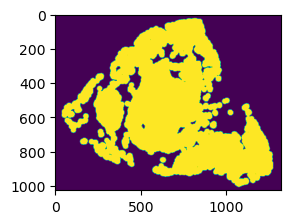

In [8]:
import matplotlib.pyplot as plt
plt.subplot(1, 2, 1)
plt.imshow(np.moveaxis(z_img["4"][0, :, 0], 0, -1))
plt.subplot(1, 2, 1)
plt.imshow(labels)
plt.show()

In this case, the labels are passed as a list of Numpy NDArrays, but these could be also stored in Zarr, either locally or in a remote S3 bucket.

In [9]:
image_specs = zds.ImagesDatasetSpecs(
  filenames=filenames,
  data_group="0",
  source_axes="TCZYX",
)

# A list with a labeled image, for the single image in the dataset, is passed as `filenames` argument.
labels_specs = zds.LabelsDatasetSpecs(
  filenames=[labels],
  source_axes="YX",
)

my_dataset = zds.ZarrDataset([image_specs, labels_specs],
                             patch_sampler=patch_sampler,
                             shuffle=True)

C:\Users\cervaf\Documents\Apps\miniconda3\envs\zds-dev\lib\site-packages\boto3\compat.py:82: PythonDeprecationWarning: Boto3 will no longer support Python 3.7 starting December 13, 2023. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.8 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
  warnings.warn(warning, PythonDeprecationWarning)


Sample 0, patch size: (1, 3, 1, 512, 512), label: (33, 33)


Sample 1, patch size: (1, 3, 1, 512, 512), label: (33, 33)


Sample 2, patch size: (1, 3, 1, 512, 512), label: (33, 33)


Sample 3, patch size: (1, 3, 1, 512, 512), label: (33, 33)


Sample 4, patch size: (1, 3, 1, 512, 512), label: (32, 33)


Sample 5, patch size: (1, 3, 1, 512, 512), label: (33, 33)


Sample 6, patch size: (1, 3, 1, 512, 512), label: (33, 33)


Sample 7, patch size: (1, 3, 1, 512, 512), label: (33, 33)


Sample 8, patch size: (1, 3, 1, 512, 512), label: (33, 33)


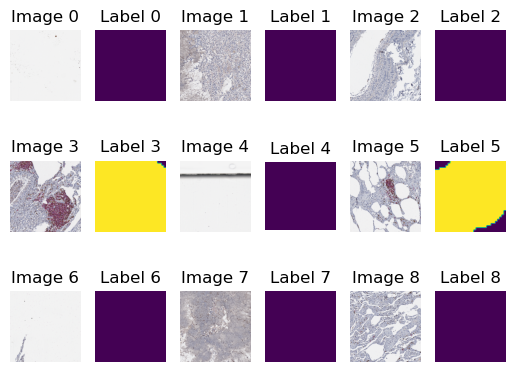

In [10]:
fig, ax = plt.subplots(3, 6)
for i, (sample, label) in enumerate(my_dataset):
    print(f"Sample {i}, patch size: {sample.shape}, label: {label.shape}")

    ax[i // 3, 2 * (i % 3)].imshow(sample[0, :, 0].transpose(1, 2, 0))
    ax[i // 3, 2 * (i % 3)].set_title(f"Image {i}")
    ax[i // 3, 2 * (i % 3)].axis("off")

    ax[i // 3, 2 * (i % 3) + 1].imshow(label)
    ax[i // 3, 2 * (i % 3) + 1].set_title(f"Label {i}")
    ax[i // 3, 2 * (i % 3) + 1].axis("off")

    # Obtain only 9 samples
    if i >= 8:
        break

plt.show()